In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
main_path = 'filtered images/c'
class_values=[]
images = [] 
for i in range(10):
    for root, dirs, files in os.walk("filtered images/c"+str(i)):  
        for filename in files:
            im_path = 'filtered images/c' + str(i) + '/' + str(filename)
            img = cv2.imread('filtered images/c' + str(i) + '/' + str(filename))
            img = cv2.resize(img, (100,100))/256
            images.append(img)
            class_values.append(i)
np_images = np.asarray(images)

In [3]:
np_images.shape

(22414, 100, 100, 3)

<b>Feature extraction using VGG16 net </b>

In [21]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten
model_base = keras.applications.vgg16.VGG16(include_top=False, input_shape=(100, 100,3), weights='imagenet')
output = model_base.output
#output = Flatten()(output)
#output = Dense(1000, activation = 'sigmoid')(output)

model = Model(model_base.input, output)
for layer in model_base.layers:
    layer.trainable = False

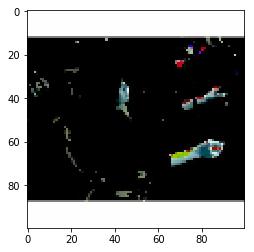

In [25]:
plt.imshow(np_images[0])

In [5]:
feature_map = model.predict(np_images)

In [6]:
feature_map.shape

(22414, 4608)

In [7]:
train_targets = np.asarray(class_values)
train_targets.shape

(22414,)

In [8]:
train_data, test_data, train_tar, test_tar = train_test_split(feature_map, train_targets, test_size = 0.2, shuffle=True)

<b>Support Vector Classifier</b>

In [11]:
from sklearn.svm import SVC
svc_classifiers = []
C_vals=[0.1, 1.0, 5, 10]
for c in C_vals:
    clf1 = SVC(C=c)
    clf1.fit(train_data, train_tar)
    print(clf1.score(test_data, test_tar)) 
    svc_classifiers.append(clf1)

0.2826232433638189
0.710461744367611
0.8601383002453714
0.9054204773589114


In [20]:
clf_final = svc_classifiers[3]
clf_final

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
#refer this file name later to load model
import pickle
filename = 'final models/svm classifier.sav'
pickle.dump(clf_final, open(filename, 'wb'))

In [14]:
y_pred = clf_final.predict(test_data)

In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    #print(cm)
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix


<Figure size 432x288 with 0 Axes>

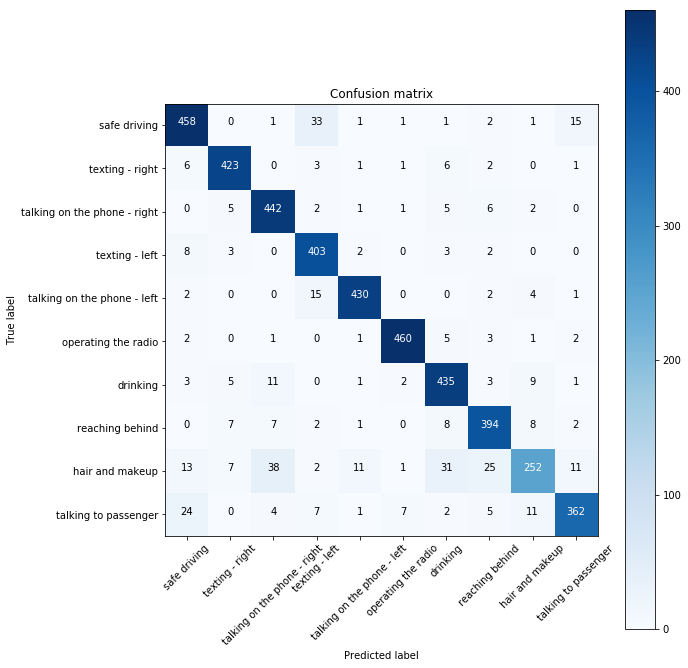

In [17]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 
               'hair and makeup', 'talking to passenger']

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [18]:
#classification report
from sklearn.metrics import confusion_matrix, classification_report
y_true = test_tar
class_names = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 
               'hair and makeup', 'talking to passenger']
print(classification_report(y_true, y_pred, target_names = class_names))

                              precision    recall  f1-score   support

                safe driving       0.89      0.89      0.89       513
             texting - right       0.94      0.95      0.95       443
talking on the phone - right       0.88      0.95      0.91       464
              texting - left       0.86      0.96      0.91       421
 talking on the phone - left       0.96      0.95      0.95       454
         operating the radio       0.97      0.97      0.97       475
                    drinking       0.88      0.93      0.90       470
             reaching behind       0.89      0.92      0.90       429
             hair and makeup       0.88      0.64      0.74       391
        talking to passenger       0.92      0.86      0.89       423

                 avg / total       0.91      0.91      0.90      4483



In [19]:
#AUC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

y_true = test_tar
multiclass_roc_auc_score(y_true, y_pred)

0.9456063374870401